# Full workflow

This notebook will keep the latest and most efficient proceedings, to allow to go through a full run on an image.
We will time each step, and make sure everything is neat.

In [1]:
import sys

# Add parent directory to Python PATH in order to allow imports from utils package
[lab_path] = ! pwd
if 'notebooks' in lab_path:
    sys.path.append("../src")
else:
    sys.path.append("src")

In [13]:
timer.start()

import os

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils.display import display_img
from utils.im_utils import otsu_bin, remove_black_blocks
from sheet.staff_lines import remove_h_lines, remove_v_lines

timer.stop("Finished imports")

Finished imports - 3.99ms


In [14]:
DATA_PATH="data"
if 'notebooks' in lab_path:
    DATA_PATH = "../data"
timer = StopWatch()

In [15]:
supported_img_extensions = ["png", "jpg"]
sample_files = [file for file in os.listdir(DATA_PATH) if file[-3:] in supported_img_extensions]


Read image from file - 31.78ms


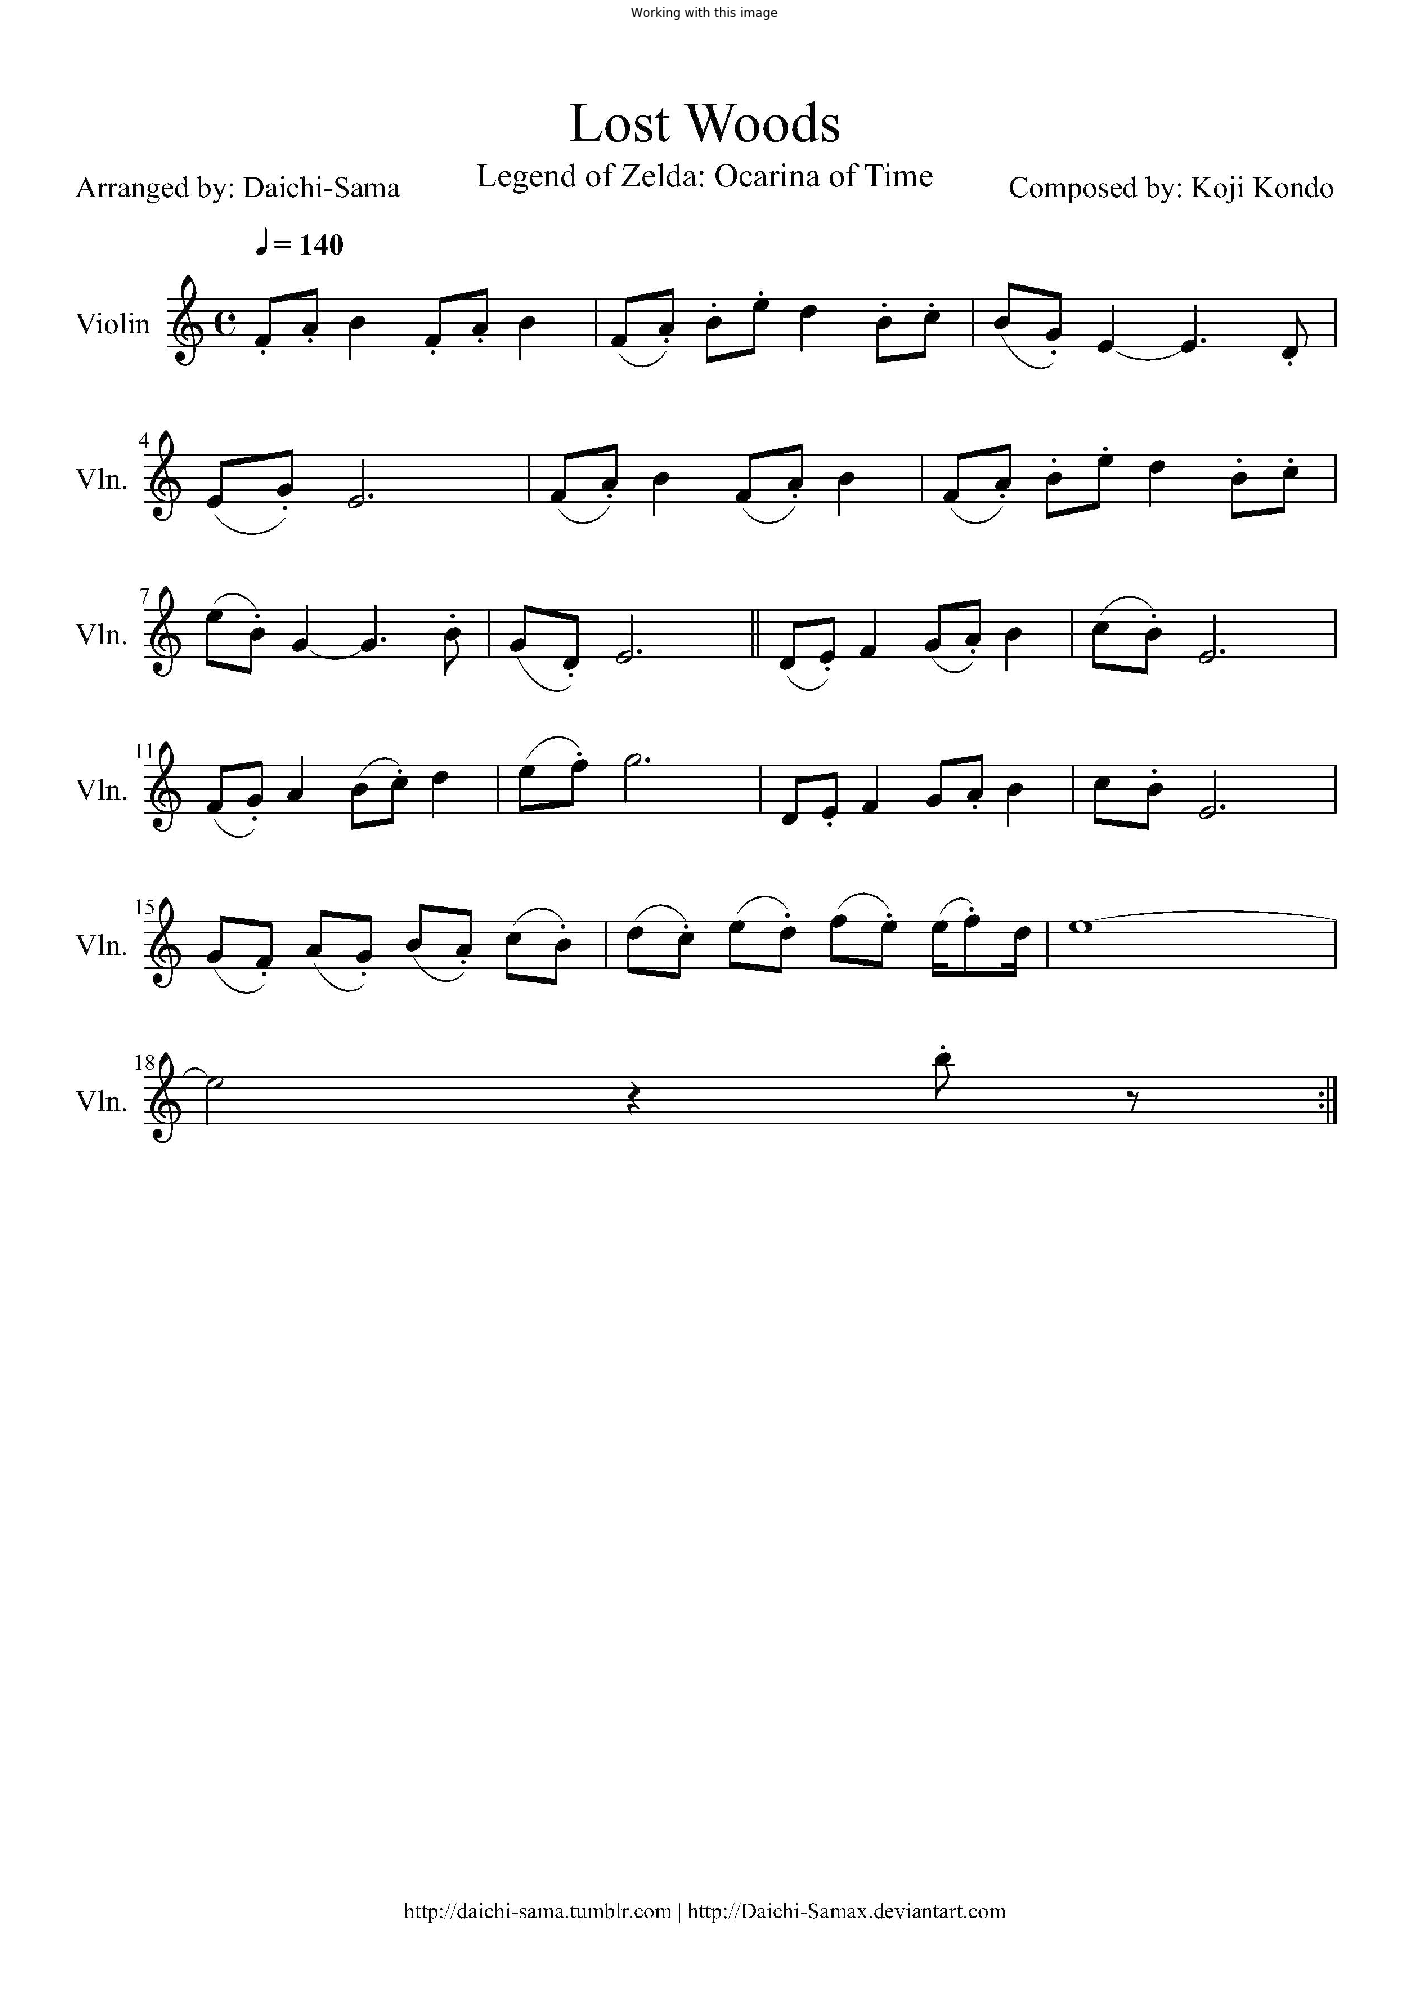

In [16]:
SELECTED_FILE = 2

timer.start()
gray_img = cv2.imread(os.path.join(DATA_PATH, sample_files[SELECTED_FILE]), 0)   
height, width = gray_img.shape
timer.stop("Read image from file")

display_img(gray_img, title="Working with this image")

## Image binarization

In [17]:
timer.start()
img = otsu_bin(gray_img)
timer.stop("Binarized image")


# display_img(img, title="Binarized image")

Binarized image - 140.05ms



## Run length encoding

In [18]:
from utils.rle import rl_encode_2D, rl_decode_2D

In [19]:
timer.start()

rle, vals = rl_encode_2D(img)

timer.stop("Done with Run-Length encoding")

Done with Run-Length encoding - 639.66ms


## Characteristics extraction

In [20]:
from utils.rle_caracteristics import get_consecutive_sum, get_most_common_consec_sum, get_sum_components, get_characteristics

In [21]:
timer.start()
    
most_common = get_most_common_consec_sum(rle)

timer.stop(f"Computed consecutive sums and computed 'line_thickness+spacing={most_common}'")

Computed consecutive sums and computed 'line_thickness+spacing=21' - 41.19ms


In [22]:
timer.start()

line_thickness, line_spacing, _ = get_characteristics(rle, most_common)

timer.stop(f"Line thickness seems to be {line_thickness}, while line spacing is {line_spacing}.")

Line thickness seems to be 3, while line spacing is 18. - 67.36ms


## Staff line removal

In [23]:
timer.start()

no_staff_line_image = remove_h_lines(img, line_thickness)

timer.stop("Decoded image from RLE to binary image")
# display_img(no_staff_line_image, title="Removed staff lines from image")

Decoded image from RLE to binary image - 1168.76ms


## Vertical line removal

Decoded image from RLE to binary image - 1076.33ms


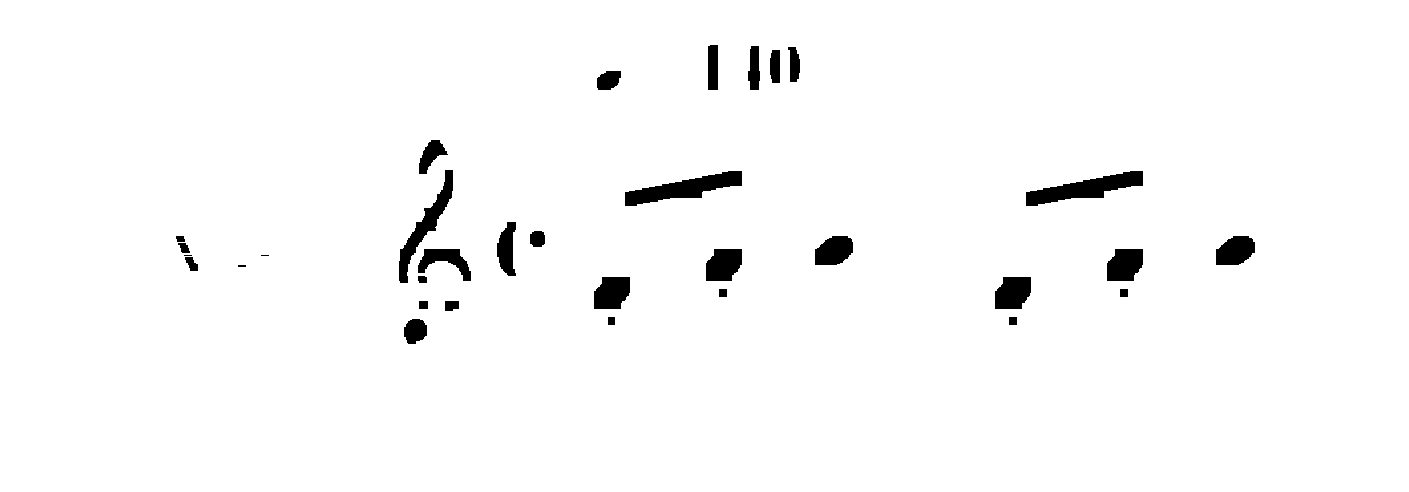

In [32]:
timer.start()
no_v_line_image = remove_v_lines(no_staff_line_image, line_thickness)

timer.stop("Decoded image from RLE to binary image")
display_img(no_v_line_image[350:710, :1050], title="")

## Interest zone detection

In [25]:
# Canny filter method
timer.start()
canny_prep_image = 255 - 255*(abs(gray_img - no_staff_line_image)).astype(np.uint8)

edges = cv2.Canny(canny_prep_image,100,200)

timer.stop("Executed Canny filter")
# display_img(edges, title="Canny filter applied to image")

Executed Canny filter - 42.38ms


Done calculating Hough Line detection - 84.54ms
Got lines in cartesian coordinates - 0.94ms
Finished selecting lines - 87.44ms


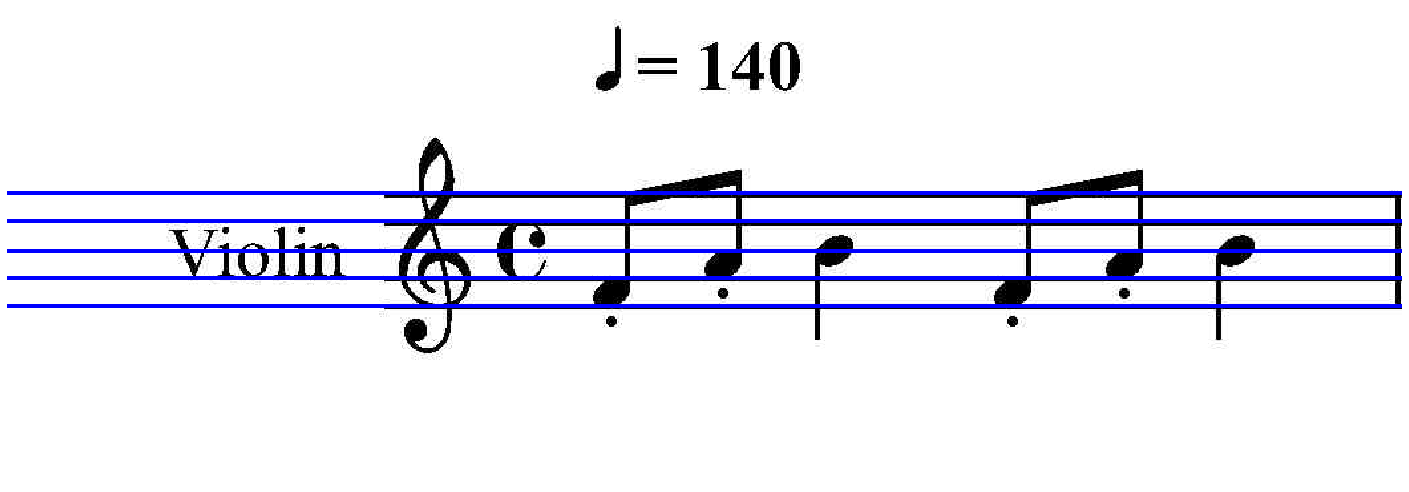

In [29]:
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)

timer.start()
lines = [(line[0][0], line[0][1]) for line in cv2.HoughLines(edges,1,np.pi/180,int(width/2),500)]
timer.lap("Done calculating Hough Line detection")
cartesian_lines = []

for rho,theta in lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    x1 = int(x0 + width*b)
    y0 = b*rho
    if a < 0.5: # Remove non horizontal lines
        cartesian_lines.append((y0, x0, x1))
    
timer.lap("Got lines in cartesian coordinates")

filtered_lines = []
cartesian_lines = sorted(cartesian_lines, key=lambda l: l[0])

for index, line in enumerate(cartesian_lines):
    if index>0  and (line[0] - filtered_lines[-1][0] < 0.9*line_spacing):
        pass
    else:
        y0, x0, x1 = line
        filtered_lines.append(line)
        cv2.line(color_img,(x0,y0),(x1,y0),(0,0,255),2)

timer.stop("Finished selecting lines")
display_img(color_img[350:710, :1050], title="")

Selected top and bottom line of each group - 0.28ms
Computed distances between consecutive lines - 0.28ms
Estimated position of zone centers - 0.29ms
Drew zones - 1.92ms


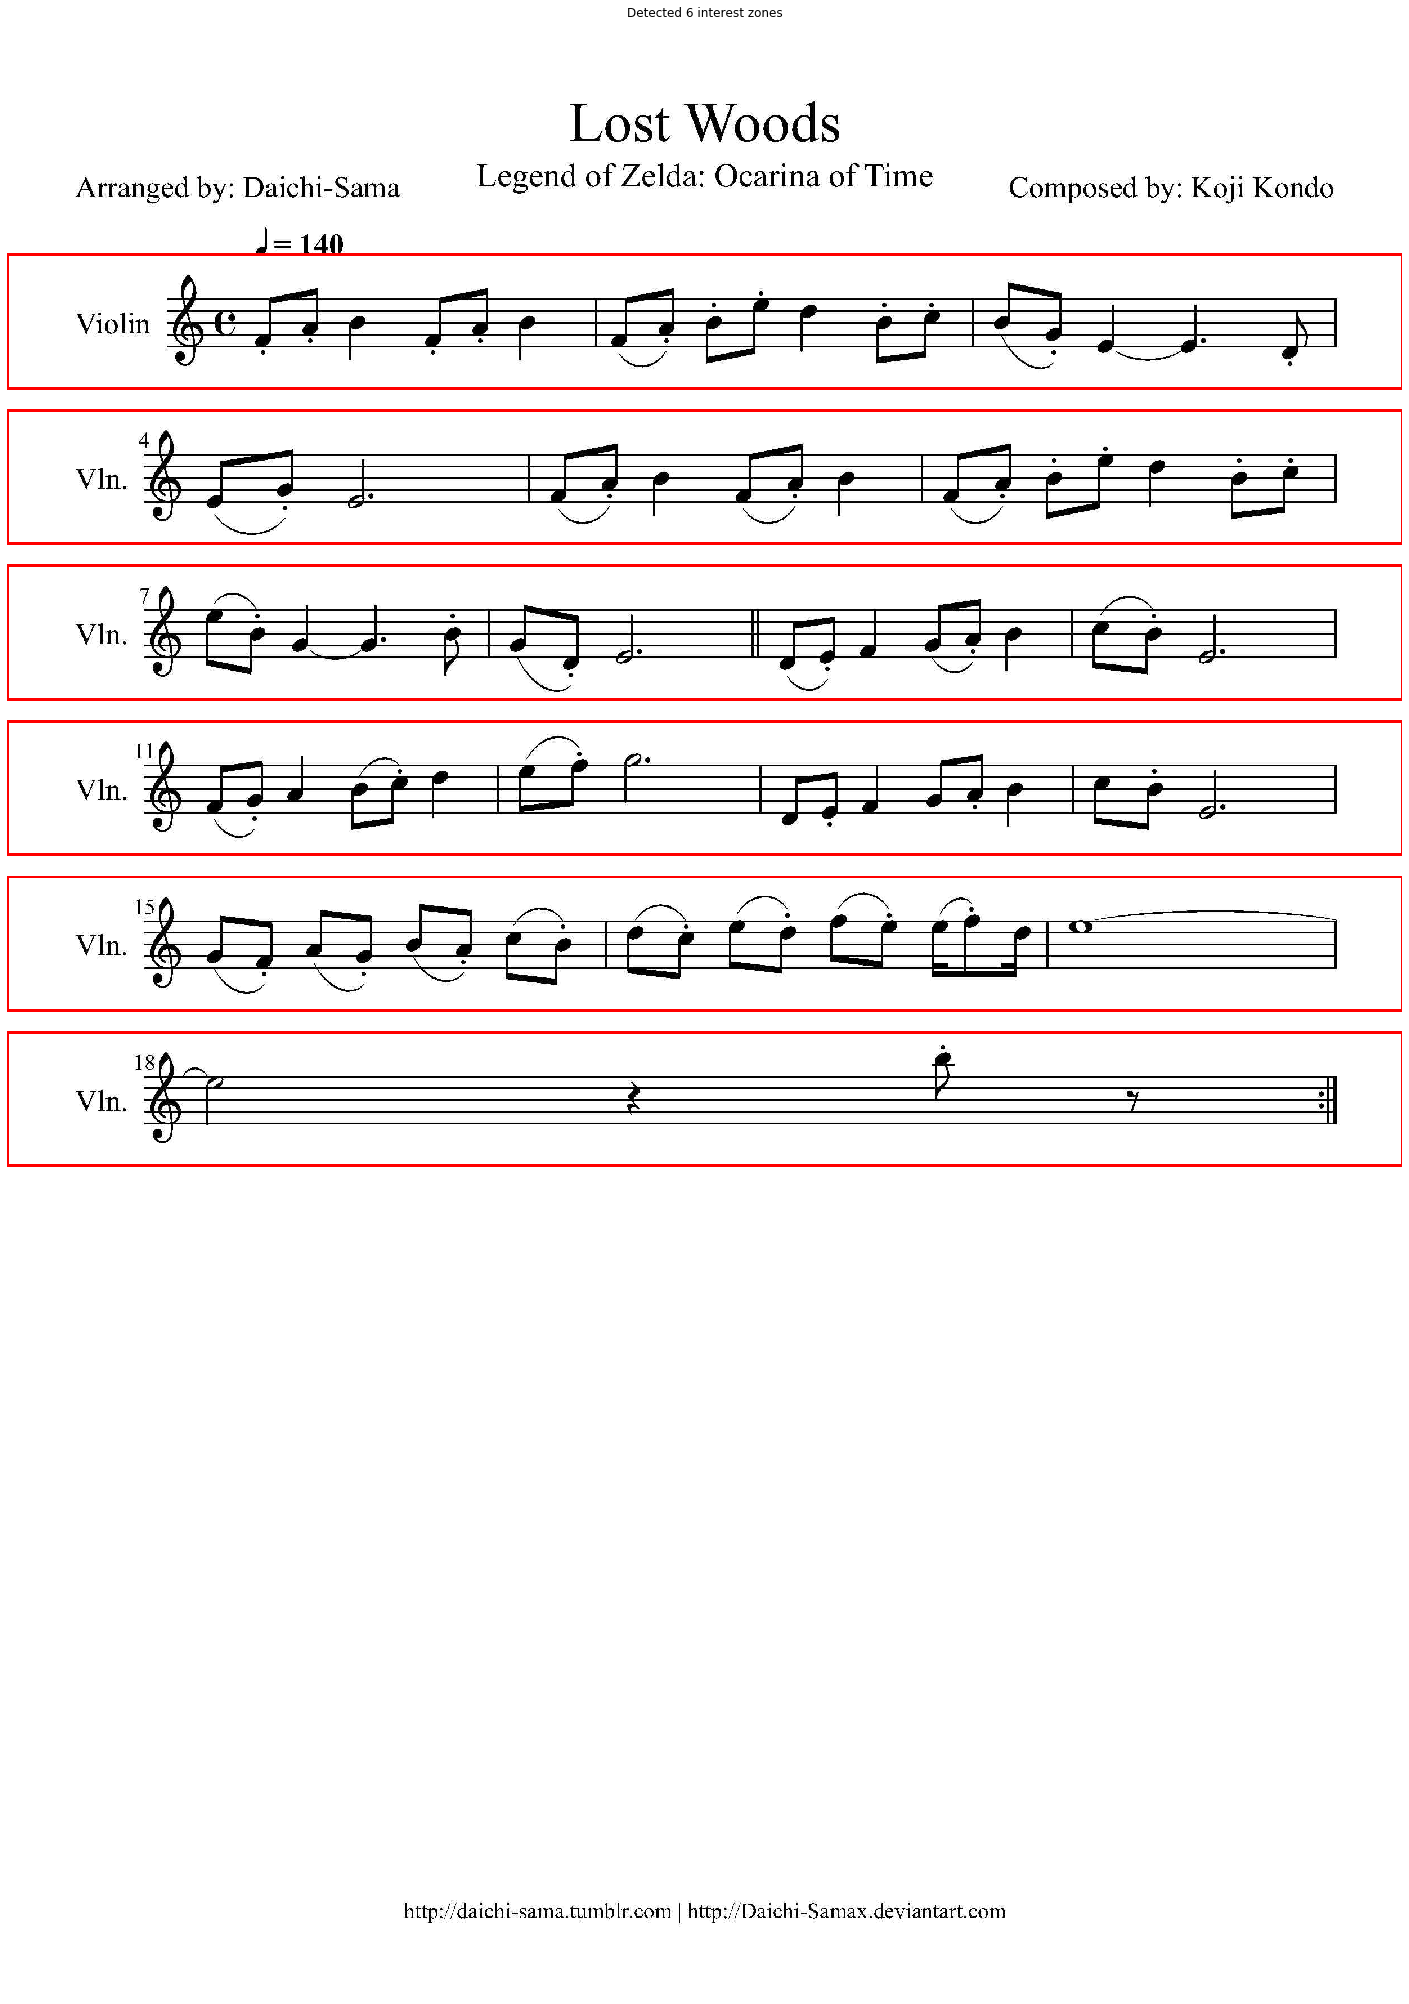

In [31]:
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
timer.start()

top_bottom_lines = []
for index, line in enumerate(filtered_lines):
    if index>0  and (line[0] - top_bottom_lines[-1][0] <= 4*line_spacing):
        pass
    else:
        y0, x0, x1 = line
        top_bottom_lines.append(line)
timer.lap("Selected top and bottom line of each group")        
        
consec_dists = []
for i in range(len(top_bottom_lines)-1):
    consec_dists.append( top_bottom_lines[i+1][0] - top_bottom_lines[i][0] )
timer.lap("Computed distances between consecutive lines")        
        
big_spacing = max(consec_dists)
box_margin = int(big_spacing/2)

centers = []
for i in range(0, len(top_bottom_lines)-1, 2):
    center_position = int((top_bottom_lines[i+1][0]-top_bottom_lines[i][0])/2)
    center_y = top_bottom_lines[i][0] + center_position
    centers.append((center_y, center_position))
timer.lap("Estimated position of zone centers")        

display_margin = int(big_spacing/10)
interest_zones = []
for index, (center, offset) in enumerate(centers):
    top = int(center) - box_margin - offset + display_margin
    bottom = int(center) + box_margin + offset - display_margin
    interest_zones.append((top, bottom))
    cv2.rectangle(color_img, (0, top), (width, bottom), (255,0,0), 3)
timer.stop("Drew zones")
    
display_img(color_img, title=f"Detected {len(centers)} interest zones")

## Pixel clustering

In [35]:
# Helper function
def get_black_pixels_in_interest_zones(image, int_zones):
    arr = np.argwhere(image == 0)
    df = pd.DataFrame(arr)
    result = None
    for top, bottom in int_zones:
        if result is None:
            result = df[(df[0] <= bottom) & (df[0] >= top)]
        else:
            result = result.append(df[(df[0] <= bottom) & (df[0] >= top)])

    return result.to_numpy(dtype=np.int32)

In [36]:
timer.start()

# Get coordinates of black pixels in interest zones
X = get_black_pixels_in_interest_zones(no_v_line_image, interest_zones) 

timer.stop("Converted binary image to coordinates of black pixels")

Converted binary image to coordinates of black pixels - 64.69ms


In [37]:
from sklearn.cluster import DBSCAN

timer.start()
db = DBSCAN(eps=2*line_thickness, min_samples=10).fit(X)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

timer.stop('Found %d clusters, and %d noise points' % (n_clusters_, n_noise_))

Found 222 clusters, and 18 noise points - 948.42ms


Grouped pixels by clister - 119.31ms
Computed cluster box boundaries - 63.91ms
Drew clusters on canvas - 187.44ms


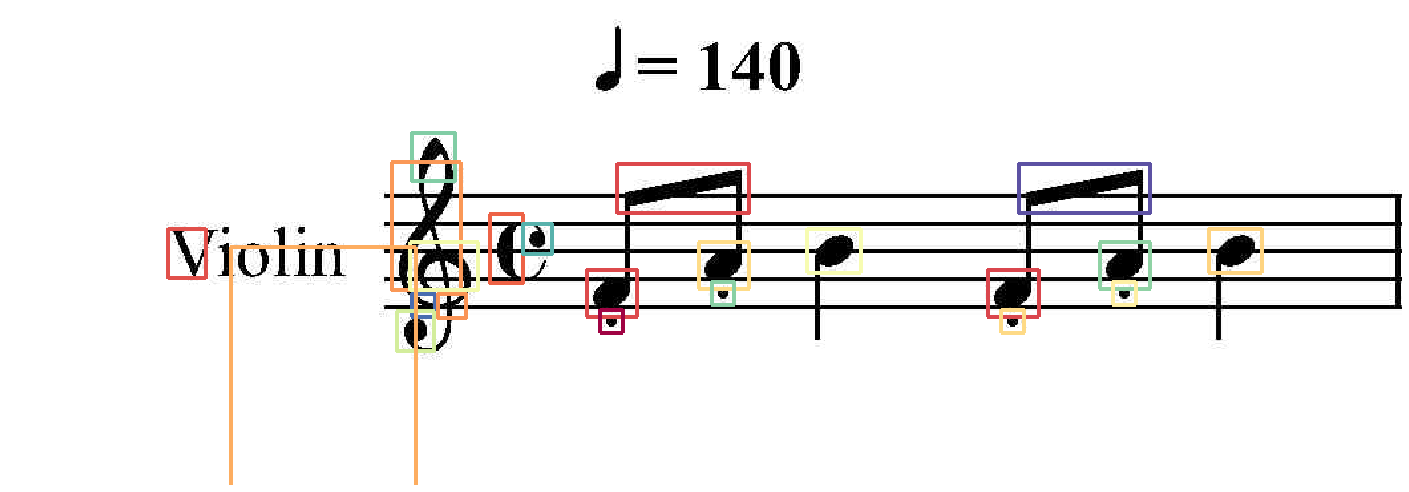

In [40]:
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, n_clusters_)])[:, :-1]*255
np.random.shuffle(colors)

timer.start()
pixels_by_cluster = [[] for i in range(n_clusters_)]
for index, label in enumerate(labels):
    if label == -1:
        pass
    if pixels_by_cluster[label]:
        pixels_by_cluster[label].append(X[index])
    else:
        pixels_by_cluster[label] = [X[index]]
timer.lap("Grouped pixels by clister")
        
cluster_boundaries = []
for cluster in pixels_by_cluster:
    cluster = np.array(cluster)
    
    top = min(cluster[:, 0])
    bottom = max(cluster[:, 0])
    left = min(cluster[:, 1])
    right = max(cluster[:, 1])
    
    cluster_boundaries.append((top, bottom, left, right))
timer.lap("Computed cluster box boundaries")

padding = 2*line_thickness
for index, (top, bottom, left, right) in enumerate(cluster_boundaries):
    color = colors[len(colors)-index-1]
    cv2.rectangle(color_img, (left-padding, top-padding), (right+padding, bottom+padding), color, 2)
    
timer.stop("Drew clusters on canvas")
    
display_img(color_img[350:710, :1050], title="")    

## Filter out non-note clusters

In [42]:
# Helper functions for cluster grouping
def rect_intersect(the_one, the_other, tolerance=0):
    top, bottom, left, right = the_one
    t, b, l, r = the_other
    
    return not (right+tolerance < l or left-tolerance > r or top-tolerance > b or bottom+tolerance < t)

def rect_intersect_any(the_one, the_others, tolerance=line_thickness):
    for other in the_others:
        if the_one != other and rect_intersect(the_one, other, tolerance=tolerance):
            return True
    return False

Filtered out clusters too small to be notes - 1.05ms
Grouped clusters together that overlap - 122.01ms
Filtered out clusters too big to be notes - 0.80ms
Filtered out non horizontal clusters - 0.18ms
Drew clusters on canvas - 2.35ms


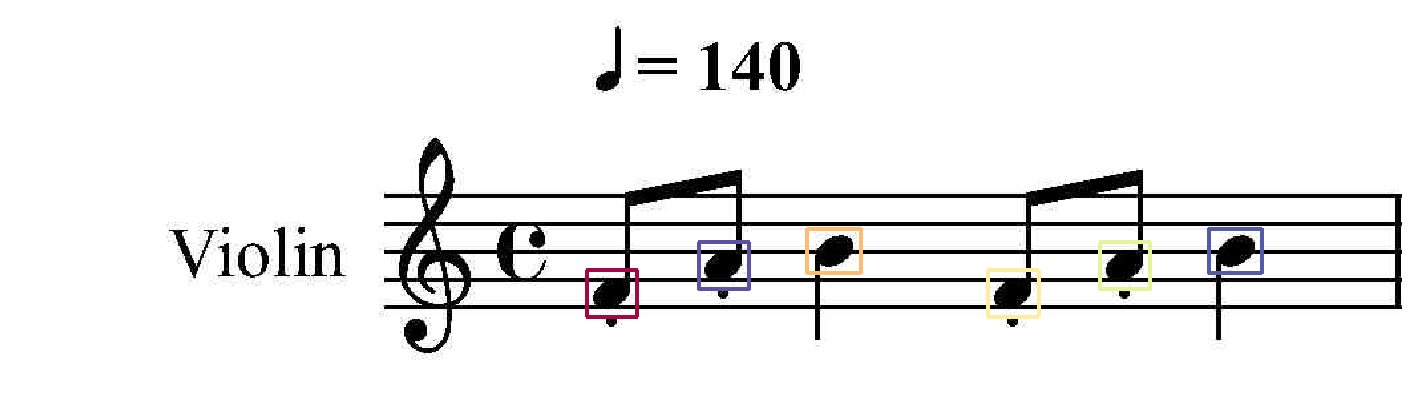

In [54]:
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, n_clusters_)])[:, :-1]*255
np.random.shuffle(colors)
timer.start()
    
# Filter note-sized clusters
vertical_min_size = line_spacing*0.5
horizontal_min_size = line_spacing*0.5
note_filtered = [cluster for cluster in cluster_boundaries if cluster[1]-cluster[0] >= vertical_min_size and cluster[3]-cluster[2] >= horizontal_min_size]


timer.lap("Filtered out clusters too small to be notes")

# Now let's regroup clusters that have areas in common
grouped_clusters = []
grouping_clusters = [[x, False] for x in note_filtered]

i = 0
while i < len(grouping_clusters):
    cluster, gr = grouping_clusters[i]
    top, bottom, left, right = cluster
    
    for j, (cl, g) in enumerate(grouping_clusters):
        t, b, l, r = cl
                                 
        if cl == cluster:
            pass
        else:
            if rect_intersect(cluster, cl, tolerance=line_spacing-line_thickness) and not g:
                gr = True
                grouping_clusters[i][1] = True
                grouping_clusters[j][1] = True
                grouped_clusters.append((
                    min(top, t), 
                    max(bottom, b), 
                    min(left, l), 
                    max(right, r)
                ))
    if not gr:
        grouped_clusters.append((top, bottom, left, right))
    i+=1
timer.lap("Grouped clusters together that overlap")

# Filter note-sized clusters
vertical_max_size = line_spacing + 2*line_thickness
horizontal_max_size = 2*line_spacing + 2*line_thickness
note_filtered = [(t,b,l,r) for t,b,l,r in grouped_clusters if b-t <= vertical_max_size and r-l <= horizontal_max_size]

timer.lap("Filtered out clusters too big to be notes")
   
# Filter for orientation to be horizontal
note_filtered = [
    (t,b,l,r) for t,b,l,r in note_filtered if r-l>b-t
]
timer.lap("Filtered out non horizontal clusters")

padding = 2*line_thickness
for index, (top, bottom, left, right) in enumerate(note_filtered):
    color = colors[index]
    cv2.rectangle(color_img, (left-padding, top-padding), (right+padding, bottom+padding), color, 2)
    
#for top, bottom in interest_zones:
#    cv2.rectangle(color_img, (0, top), (width, bottom), (255,0,0), 2)
    
timer.lap("Drew clusters on canvas")

display_img(color_img[350:640, :1050], title="")    

## Finding note height

Notes in midi have the following code. On a music sheet however, only a couple of these appear. We add these in the `all_full_notes` list, and use F5 to spot all other notes. F5 is our choice, because it corresponds to the first staff line, when read from top to bottom.

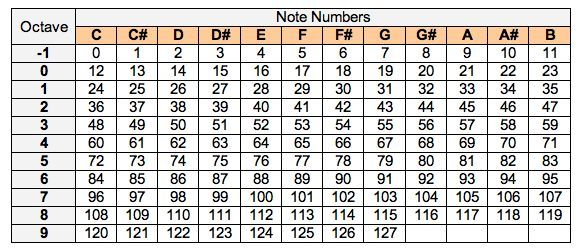

In [55]:
base_full_notes = [0, 2, 4, 5, 7, 9, 11]
all_full_notes = sorted([note+i*12 for note in base_full_notes for i in range(10)])
F5_index = all_full_notes.index(77)

def get_lines_by_zone(interest_zones, identified_lines):
    lines_by_zone = [[] for i in range(len(interest_zones))]
    for index, (top, bottom) in enumerate(interest_zones):
        for line in filtered_lines:
            if line[0] > top and line[0] < bottom:
                lines_by_zone[index].append(line[0])
    return lines_by_zone

def get_grid_by_zone(interest_zones, identified_lines, spacer):
    lines_by_zone = get_lines_by_zone(interest_zones, identified_lines)
    
    for index, zone in enumerate(lines_by_zone):
        lines_above = []
        top_line = zone[0] - spacer
        while top_line > interest_zones[index][0]:
            lines_above.append(top_line)
            top_line = top_line - spacer

        lines_below = []
        bottom_line = zone[-1] + spacer
        while bottom_line < interest_zones[index][1]:
            lines_below.append(bottom_line)
            bottom_line = bottom_line + spacer

        lines_between = [(zone[i] + zone[i+1])/2 for i in range(len(zone)-1)]
        
        lines = sorted(np.array(lines_above + zone + lines_below + lines_between, dtype=np.int32))
        notes = [all_full_notes[F5_index+len(lines_above)-i] for i in range(len(lines))]
        
        lines_by_zone[index] = interest_zones[index], lines, notes
        
    return lines_by_zone

def is_in_zone(pixel, interest_zone):
    top, bottom = interest_zone
    x, y = pixel
    return x >= top and x <= bottom

def get_zone_for_pixel(pixel, interest_zones):
    for index, zone in enumerate(interest_zones):
        if is_in_zone(pixel, zone):
            return index

In [56]:
timer.start()
spacer = (line_spacing + line_thickness)/2

grid = get_grid_by_zone(interest_zones, filtered_lines, spacer)
    
timer.stop("Built grid to match notes in each zone")

Built grid to match notes in each zone - 1.04ms


In [57]:
timer.start()

# sort clusters by zone
clusters_by_zone = [[] for i in range(len(interest_zones))]
for cluster in note_filtered:
    t, b, l, r = cluster
    center = (b + t)/2, (r + l)/2
    zone_idx = get_zone_for_pixel(center, interest_zones)
    zone, lines, notes = grid[zone_idx]
    distances = [abs(center[0]-line) for line in lines]
    note_height = notes[np.argmin(distances)]
    clusters_by_zone[zone_idx].append((cluster, note_height))
    
timer.lap("Associated a note to each cluster")

clusters_by_zone = [sorted(c_zone, key=lambda x: x[0][2]) for c_zone in clusters_by_zone]

timer.stop("Sorted results by horizontal appearance in a line")


Associated a note to each cluster - 3.22ms
Sorted results by horizontal appearance in a line - 3.57ms


## Playing the notes

In [272]:
from mido import Message, MidiFile, MidiTrack

NOTE_DURATION = 256
BETWEEN_NOTE_SPACE = 64

def save_notes_to_midi_files(notes):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(Message('program_change', program=12, time=0))

    for i, note in enumerate(notes):
        track.append( Message('note_on',  note=note, time=BETWEEN_NOTE_SPACE) )    
        track.append( Message('note_off', note=note, time=NOTE_DURATION)  )
        
    mid.save('new_song.mid')

In [273]:
timer.start()

note_succession = [[cluster[1] for cluster in zone] for zone in clusters_by_zone]
flat_note_succession = [note for notes in note_succession for note in notes]

timer.lap("Built flat list of all notes in succession")

save_notes_to_midi_files(flat_note_succession)

timer.stop("Saved to midi file")

Built flat list of all notes in succession - 0.21ms
Saved to midi file - 6.93ms


In [274]:
import pygame     

freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

pygame.mixer.music.load('new_song.mid')

In [277]:
pygame.mixer.music.play()

In [278]:
pygame.mixer.music.stop()

## Detecting rythm